<a href="https://colab.research.google.com/github/brunodino/dio-lab-open-source/blob/main/00_ML_Python_intro_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Preâmbulo (lendo bibliotecas e shapefiles)](#scrollTo=Fom6EkCRB92g)

>[Criando o banco de dados (sintético)](#scrollTo=wX2M0vtVtvhi)

>>[Plotando o primeiro gráfico com os dados sintéticos](#scrollTo=jSlSXBxzC_ko)

>['Handmade' Linear Regression - Minha primeira regressão](#scrollTo=EDB0Scti7SpQ)

>>[Revisão rápida de estatística básica](#scrollTo=8rNF6-JQLSna)

>>>[Tendências Centrais](#scrollTo=JI7Fyc4JS0-R)

>>>[Dispersão](#scrollTo=bPZvfDKgTBtz)

>>>[Covariância e Correlação](#scrollTo=V6jT44EATMuU)

>>[Introdução à regressão linear simples](#scrollTo=j75MffwAUlTW)

>>[Encontrando o termo de erro (least squared errors)](#scrollTo=SVSwlz8EL6jQ)

>>[Minhas primeiras predições usando Regressão Linear](#scrollTo=KhG7En32k_LG)

>['Handmade' KNN - Meu primeiro classificador](#scrollTo=sk5nRURSUwqc)

>>[Definindo métodos para o KNN](#scrollTo=rC1Wr87whr-s)

>>[Treino e teste (80/20)](#scrollTo=JPMFm1Kuhyg7)

>>[Estrutura de dados para o modelo](#scrollTo=_sn1RBJulgFH)

>>[Plotando os pontos (treino e teste) no mapa](#scrollTo=-vBmVhzzooiN)

>>[Minhas primeiras predições](#scrollTo=FSD19XMInyKA)

>>[O quanto acertamos?](#scrollTo=2jge9ysktuuP)

>>[Apresentando algumas métricas](#scrollTo=XzMpHJh1t1yr)

>[Qualificando as predições](#scrollTo=i2JZvyheu212)

>[Matrix de confusão](#scrollTo=i2JZvyheu212)

>[Tabela de Métricas](#scrollTo=i2JZvyheu212)



# Preâmbulo (lendo bibliotecas e shapefiles)

In [ ]:
from __future__ import division
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import math
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
# CÓDIGO ALTERNATIVO USANDO O naturalearthdata.com
# # Usando o geopandas para carregar um shapefile do Brasil (Geopandas oferece datasets prontos)
# # Baixar aqui: https://drive.google.com/drive/folders/100FIxCuB1wcsPMVaW1PNrJWYjkEOUUdv?usp=sharing
# # Ou aqui: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

# shapefile_path = "/content/drive/MyDrive/00_PROFESSOR/UFBA/99_Tomorrow_Positivo/04_Ciência_De_Dados_Python/03-colabs/data/naturalearthdata.com/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

# # Carregar o shapefile
# world = gpd.read_file(shapefile_path)

# # Filtrar apenas o Brasil
# brasil = world[world['ADMIN'] == 'Brazil']

In [ ]:
# Substitua pelos caminhos corretos dos shapefiles baixados
shapefile_pais = "/content/drive/MyDrive/00_PROFESSOR/UFBA/99_Tomorrow_Positivo/04_Ciência_De_Dados_Python/03-colabs/data/ibge.gov.br/BR_Pais_2023/BR_Pais_2023.shp"
shapefile_regioes = "/content/drive/MyDrive/00_PROFESSOR/UFBA/99_Tomorrow_Positivo/04_Ciência_De_Dados_Python/03-colabs/data/ibge.gov.br/BR_Regioes_2023/BR_Regioes_2023.shp"
shapefile_estados = "/content/drive/MyDrive/00_PROFESSOR/UFBA/99_Tomorrow_Positivo/04_Ciência_De_Dados_Python/03-colabs/data/ibge.gov.br/BR_UF_2023/BR_UF_2023.shp"
shapefile_municipios = "/content/drive/MyDrive/00_PROFESSOR/UFBA/99_Tomorrow_Positivo/04_Ciência_De_Dados_Python/03-colabs/data/ibge.gov.br/BR_Municipios_2023/BR_Municipios_2023.shp"

# Carregar os shapefiles
brasil = gpd.read_file(shapefile_pais)
regioes = gpd.read_file(shapefile_regioes)
estados = gpd.read_file(shapefile_estados)
municipios = gpd.read_file(shapefile_municipios)

# **Criando o banco de dados (sintético)**

In [ ]:
# Criando semente para orientar a aleatoriedade
np.random.seed(1)
# Coordenadas dos pontos (latitude, longitude)
# coordenadas = [
#     (-22.9068, -43.1729),  # Rio de Janeiro
#     (-23.5505, -46.6333),  # São Paulo
#     (-15.7942, -47.8822)   # Brasília
# ]

min_x, min_y, max_x, max_y = brasil.total_bounds

# Criar dados simulados
n_pontos = 280

"""
O comando np.random.uniform produz pontos usando a distribuição uniforme numa bounding box (retângulo).
Mesmo definindo os valores minimos e máximos, é possível que alguns pontos sejam gerados
Fora dos limites do Brasil num retângulo que caiba o país.
Por isso, decidi fazer uma verificação ponto a ponto para incluir apenas os válidos
e garantir que teremos 100 registros no dataset final.

Caso se deseje fazer esta verificação, pode-se substituir o código seguinte por:

pontos_validos = []

while len(pontos_validos) < n_pontos:
    # Gerar coordenadas aleatórias
    x = np.random.uniform(min_x, max_x)
    y = np.random.uniform(min_y, max_y)
    ponto = Point(x, y)

    # Verificar se o ponto está dentro do Brasil
    if ponto.within(brasil.union_all()):
        pontos_validos.append(ponto)


# Filtros simples para garantir que os pontos estejam no Brasil
pontos = gpd.GeoDataFrame(geometry=pontos_validos, crs="EPSG:4326")

ATENCAO: isso pode demorar bastante uma vez que não se tem qualquer controle sobre quando se
completará a produção dos 100 pontos válidos, uma alternativa é criar uma variável
'n_pontos' com um número que produza um volume de pontos válidos próximo do desejado.
Com a np.random.seed(1), consegui 104 registros.
"""

# Criando pontos dentro dos limites
coordenadas_x = np.random.uniform(min_x, max_x, n_pontos)
coordenadas_y = np.random.uniform(min_y, max_y, n_pontos)

# Filtros simples para garantir que os pontos estejam no Brasil
pontos = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(coordenadas_x, coordenadas_y),
    crs="EPSG:4326"
)
pontos = pontos[pontos.geometry.within(brasil.union_all())]

# removendo pontos inválidos ou nulos
pontos = pontos[pontos.geometry.notnull()]

# Gerar atributos adicionais
# tempo_experiencia e pull_requests são casos especiais
tempo_experiencia = np.random.randint(0, 10, len(pontos))
# Forçando uma relação linear + ruído entre o tempo de experiência e pull_requests
pull_requests = 2 * tempo_experiencia + np.random.randint(0, 10, len(pontos))

# Forçando que o numero de projetos ativos tenha uma relação linear com
# a quantidade de pull requests
projetos_ativos = 4 * pull_requests + np.random.randint(0, 5, len(pontos))

dados = pd.DataFrame({
    'tempo_experiencia': tempo_experiencia,
    'pull_requests': pull_requests,
    'tipo_contribuicao': np.random.choice(['Codigo', 'Documentacao', 'Testes', 'Outros'], len(pontos), p=[0.3, 0.25, 0.4, 0.05]),
    'area_aplicacao': np.random.choice(['Educacao', 'Saude', 'Financas', 'Outros'], len(pontos), p=[0.1, 0.3, 0.5, 0.1]),
    'projetos_ativos': projetos_ativos,
    'horas_semanais': np.random.choice([8, 20, 40, 44], len(pontos), p=[0.1, 0.3, 0.5, 0.1]),
    'linguagem': np.random.choice(['Python', 'R'], len(pontos), p=[0.6, 0.4])  # 60% Python, 40% R
})
pontos = gpd.GeoDataFrame(pd.concat([dados, pontos.reset_index(drop=True)], axis=1))

In [ ]:
dados

,tempo_experiencia,pull_requests,tipo_contribuicao,area_aplicacao,projetos_ativos,horas_semanais,linguagem
0,1,8,Documentacao,Financas,2,20,Python
1,9,27,Codigo,Financas,2,20,Python
2,6,17,Testes,Saude,0,8,R
3,0,4,Codigo,Financas,1,40,Python
4,2,11,Testes,Financas,4,40,Python
...,...,...,...,...,...,...,...
99,8,20,Testes,Saude,0,40,Python
100,1,10,Testes,Financas,4,8,Python
101,8,20,Testes,Outros,1,20,Python
102,6,15,Codigo,Saude,4,40,Python


In [ ]:
pontos

,tempo_experiencia,pull_requests,tipo_contribuicao,area_aplicacao,projetos_ativos,horas_semanais,linguagem,geometry
0,1,8,Documentacao,Financas,2,20,Python,POINT (-55.1649 0.58901)
1,9,27,Codigo,Financas,2,20,Python,POINT (-58.39087 -2.44843)
2,6,17,Testes,Saude,0,8,R,POINT (-56.07925 -11.41095)
3,0,4,Codigo,Financas,1,40,Python,POINT (-49.66675 -5.14174)
4,2,11,Testes,Financas,4,40,Python,POINT (-55.06683 -13.49778)
...,...,...,...,...,...,...,...,...
99,8,20,Testes,Saude,0,40,Python,POINT (-45.91526 -4.29303)
100,1,10,Testes,Financas,4,8,Python,POINT (-54.56788 -15.65005)
101,8,20,Testes,Outros,1,20,Python,POINT (-43.39261 -21.55643)
102,6,15,Codigo,Saude,4,40,Python,POINT (-54.72797 -7.45556)


## Plotando o primeiro gráfico com os dados sintéticos

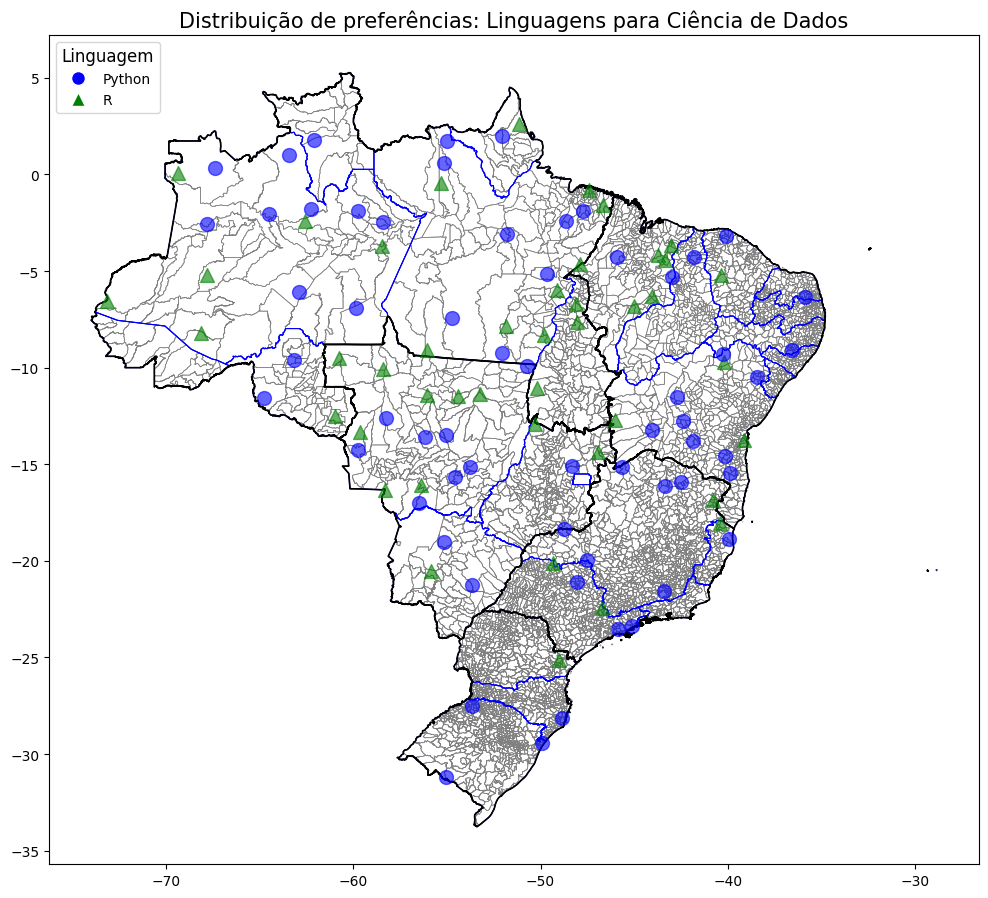

In [ ]:
# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 12))

# Adicionando cada camada
brasil.plot(ax=ax, color='white', linewidth=0.2, edgecolor='red', label='Brasil')
municipios.plot(ax=ax, color='none', linewidth=0.5, edgecolor='gray', label='Municípios')
estados.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.8, label='Estados')
regioes.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2, label='Regiões')

# Caso se deseje plotar os pontos sem discriminação de linguagem
# pontos.plot(ax=ax, color='green', markersize=100, label='Cidades')  # Adicionar pontos

# Plotar pontos com marcadores diferentes para Python e R
for _, row in pontos.iterrows():
    if row.geometry:  # Só certificando que a geometria não é None
        if row['linguagem'] == 'Python':
            ax.scatter(row.geometry.x, row.geometry.y, color='blue', marker='o',
                       s=100, alpha=0.6)
        elif row['linguagem'] == 'R':
            ax.scatter(row.geometry.x, row.geometry.y, color='green', marker='^',
                       s=100, alpha=0.6)


# Criar handles para legenda personalizada
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Python'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='R')
]

# pontos.plot(ax=ax, color=pontos['linguagem'].map({'Python': 'blue', 'R': 'green'}),
#             markersize=100, alpha=0.6, label='Desenvolvedores')

# Personalização
ax.legend(handles=handles, title="Linguagem", loc="upper left", fontsize=10, title_fontsize=12)
plt.title("Distribuição de preferências: Linguagens para Ciência de Dados", fontsize=15)
plt.show()

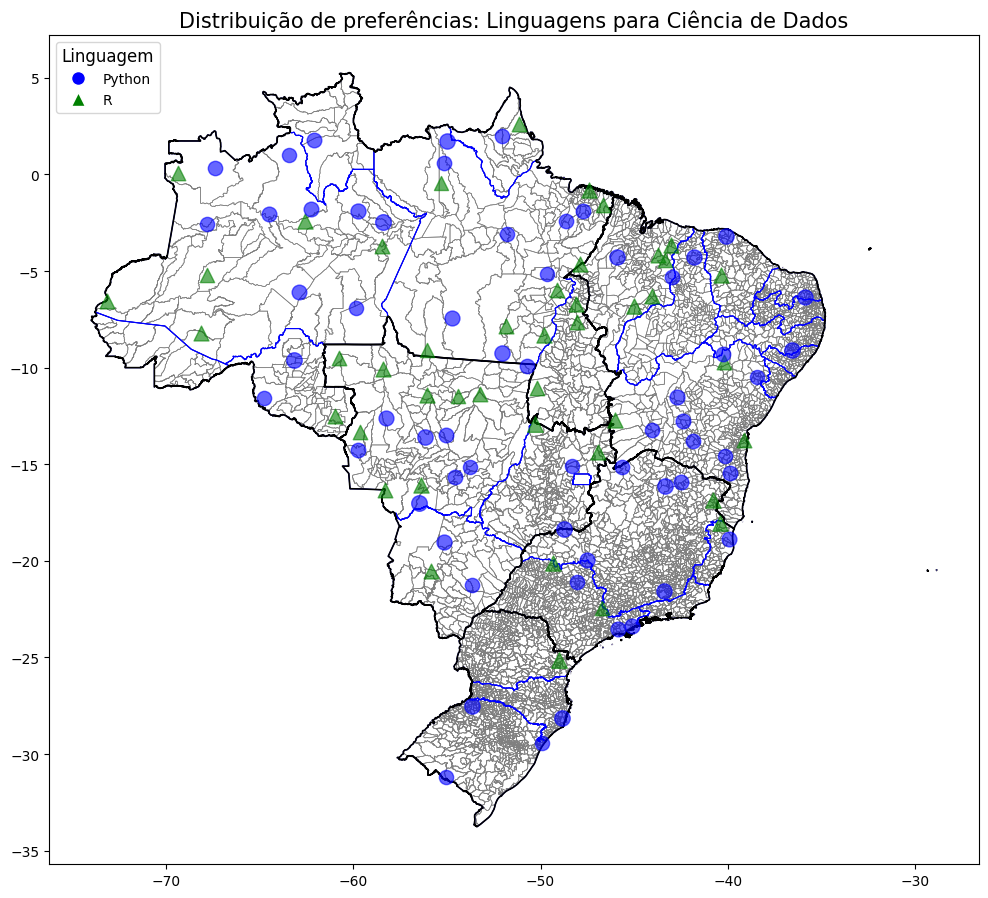

In [ ]:
# Aumentando os pontos de acordo com o número de pull requests
# Plotando o mapa
fig, ax = plt.subplots(figsize=(12, 12))

# Adicionar cada camada
brasil.plot(ax=ax, color='white', linewidth=0.2, edgecolor='red', label='Brasil')
municipios.plot(ax=ax, color='none', linewidth=0.5, edgecolor='gray', label='Municípios')
estados.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.8, label='Estados')
regioes.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2, label='Regiões')

# Caso se deseje plotar os pontos sem discriminação de linguagem
# pontos.plot(ax=ax, color='green', markersize=100, label='Cidades')  # Adicionar pontos

# Pontos com marcadores diferentes para Python e R
for _, row in pontos.iterrows():
    if row.geometry:  # Só certificando que a geometria não é None
        if row['linguagem'] == 'Python':
            ax.scatter(row.geometry.x, row.geometry.y, color='blue', marker='o',
                       s=row['pull_requests'] + 100, alpha=0.6)
        elif row['linguagem'] == 'R':
            ax.scatter(row.geometry.x, row.geometry.y, color='green', marker='^',
                       s=row['pull_requests'] + 100, alpha=0.6)


# Criar handles para legenda personalizada
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Python'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='R')
]

# pontos.plot(ax=ax, color=pontos['linguagem'].map({'Python': 'blue', 'R': 'green'}),
#             markersize=100, alpha=0.6, label='Desenvolvedores')

# Personalização
ax.legend(handles=handles, title="Linguagem", loc="upper left", fontsize=10, title_fontsize=12)
plt.title("Distribuição de preferências: Linguagens para Ciência de Dados", fontsize=15)
plt.show()

# 'Handmade' Linear Regression - Minha primeira regressão

## Revisão rápida de estatística básica

### Tendências Centrais

In [ ]:
def dot(v, w):
  """v_1 * w_1 + ... + v_n * w_n"""
  return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
  """v_1 * v_1 + ... + v_n * v_n"""
  return dot(v, v)

**Média**: A média é a soma dos valores dividida pelo número de elementos.

   $
   \mu = \frac{1}{n} \sum_{i=1}^{n} x_i
   $

Onde:

$\mu$: Média

$n$: Número de elementos

$x_i$:Valores individuais

In [ ]:
def mean(x):
  return sum(x) / len(x)

**Mediana**: A mediana é o valor central dos dados ordenados.

In [ ]:
def median(v):
  """encontra o valor mais ao meio de v"""
  n = len(v)
  sorted_v = sorted(v)
  midpoint = n // 2
  if n % 2 == 1:
    # se for ímpar, retorna o valor do meio
    return sorted_v[b]
  else:
    # se for par, retorna a média dos valores do meio
    lo = midpoint - 1
    hi = midpoint
    return (sorted_v[lo] + sorted_v[hi]) / 2

**Moda**: A moda é o valor que aparece com mais frequência.

In [ ]:
def mode(x):
  """retorna uma lista, pode haver mais de uma moda"""
  counts = Counter(x)
  max_count = max(counts.values())
  return [x_i for x_i, count in counts.items() if count == max_count]

In [ ]:
v = [1, 1, 4, 4, 4, 6, 92, 334, 2, 3, 5, 2, 1]

In [ ]:
c = Counter(v)

In [ ]:
c

Counter({1: 3, 4: 3, 6: 1, 92: 1, 334: 1, 2: 2, 3: 1, 5: 1})

In [ ]:
max_count = max(c.values())
max_count

3

In [ ]:
 [x_i for x_i, count in c.items() if count == max_count]

[1, 4]

`Inspeção`

In [ ]:
print("""
Anos de experiência:
\tMédia {},
\tMediana {},
\tModa {}.""".format(mean(list(pontos["tempo_experiencia"])),
                   median(list(pontos["tempo_experiencia"])),
                   mode(list(pontos["tempo_experiencia"]))))


Anos de experiência:
	Média 4.221153846153846,
	Mediana 4.0,
	Moda [1, 2].


### Dispersão

**Desvio Médio**: O desvio médio é a média das distâncias absolutas entre cada valor e a média dos dados.


   $
   D = \frac{1}{n} \sum_{i=1}^{n} |x_i - \mu|
   $

Onde:

$D$: Desvio médio

$x_i$: Valores individuais

$\mu$: Média

$n$: Número de elementos


In [ ]:
# Desvio médio
def de_mean(x):
  """desloca x ao subtrair sua média (então o resultado tem a média 0)"""
  x_bar = mean(x)
  return [x_i - x_bar for x_i in x]

**Variância**: A variância é a média dos quadrados das diferenças entre cada valor e a média.

   $
   \sigma^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2
   $

Onde:

$\sigma^2$: Variância

$x_i$: Valores individuais

$\mu$: Média

$n$: Número de elementos


In [ ]:
# Variancia
def variancia(x):
  """presume que x tem ao menos dois elementos"""
  n = len(x)
  deviations = de_mean(x)
  return sum_of_squares(deviations) / (n - 1)

**Desvio Padrão**: O desvio padrão é a raiz quadrada da variância e representa o quanto os dados variam em relação à média.


   $
   \sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}
   $

Onde:

$\sigma$: Desvio Padrão

$x_i$: Valores individuais

$\mu$: Média

$n$: Número de elementos


In [ ]:
def desvio_padrao(x):
  return math.sqrt(variancia(x))

`Inspeção`

In [ ]:
print("""
Anos de experiência:
\tDesvio Médio {},
\tVariança {},
\tDesvio Padrão {}.""".format(de_mean(list(pontos["tempo_experiencia"])),
                   variancia(list(pontos["tempo_experiencia"])),
                   desvio_padrao(list(pontos["tempo_experiencia"]))))


Anos de experiência:
	Desvio Médio [-3.221153846153846, 4.778846153846154, 1.7788461538461542, -4.221153846153846, -2.221153846153846, 3.778846153846154, -1.2211538461538458, 2.778846153846154, -2.221153846153846, 0.7788461538461542, 1.7788461538461542, -4.221153846153846, -0.2211538461538458, -2.221153846153846, -1.2211538461538458, -3.221153846153846, -4.221153846153846, 0.7788461538461542, 2.778846153846154, -4.221153846153846, -2.221153846153846, -2.221153846153846, -4.221153846153846, 4.778846153846154, 0.7788461538461542, -3.221153846153846, -3.221153846153846, 1.7788461538461542, -1.2211538461538458, -2.221153846153846, -3.221153846153846, -3.221153846153846, -2.221153846153846, 2.778846153846154, 0.7788461538461542, -2.221153846153846, 4.778846153846154, -0.2211538461538458, 2.778846153846154, -1.2211538461538458, 0.7788461538461542, -4.221153846153846, -2.221153846153846, -3.221153846153846, -0.2211538461538458, 4.778846153846154, -0.2211538461538458, 1.7788461538461542, 4.77

### Covariância e Correlação

**Covariância**: A covariância mede o quanto duas variáveis mudam juntas.

   $
   \text{cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (x_i - \mu_X)(y_i - \mu_Y)
   $

Onde:

$cov(X,Y)$: Covariância entre as variáveis

$x_i, y_i$: Valores das variáveis X e Y

$\mu_X, \mu_Y$: Média das variáveis X e Y

$n$: Número de elementos

In [ ]:
def covarianca(x, y):
  n = len(x)
  return dot(de_mean(x), de_mean(y)) / (n - 1)

**Correlação**: A correlação é a medida de quão fortemente duas variáveis estão linearmente relacionadas.


   $
   \rho_{XY} = \frac{\text{cov}(X, Y)}{\sigma_X \sigma_Y}
   $


Onde:

$\rho_{XY}$: Correlação entre as variáveis X e Y

$cov(X,Y)$: Covariância entre as variáveis X e Y

$\sigma_X, σ_y$: Desvio Padrão das variáveis X e Y


In [ ]:

def correlacao(x, y):
  stdev_x = desvio_padrao(x)
  stdev_y = desvio_padrao(y)
  if stdev_x > 0 and stdev_y > 0:
    return covarianca(x, y) / stdev_x / stdev_y
  else:
    return 0 # se não houver amplitude, a correlação é zero

`Inspeção`

In [ ]:
print("""
Anos de experiência x pull_requests:
\tCovarianca {},
\tCorrelação {}.""".format(covarianca(list(pontos["tempo_experiencia"]), list(pontos["pull_requests"])),
                           correlacao(list(pontos["tempo_experiencia"]), list(pontos["pull_requests"]))))


Anos de experiência x pull_requests:
	Covarianca 17.122946228528757,
	Correlação 0.9094689660682255.


In [ ]:
# Verificando a correlação entre Tempo de Experiência e Pull Requests
# Usando o próprio pandas.
df = pontos[['tempo_experiencia', 'pull_requests']]
df.corr().loc["tempo_experiencia", "pull_requests"]

0.9094689660682257

## Introdução à regressão linear simples

Suponha que você encontrou um relacionamento linear forte entre as variáveis de *Tempo de Experiência* e *Pull Requests*. Neste caso, um modelo capaz de explicar esta relação é o de Regressão Linear.

Em particular, você cria uma hipótese de que há constantes α (alfa) e β (beta) tais que:

$ y_i = \beta x_i + \alpha + \epsilon_i $

Onde:

- $y_i$: É o número de Pull Requests do desenvolvedor $i$, denominado de variável dependente (resposta).
- $x_i$: É o número de anos em Tempo de Experiência, denominado variável independente (preditor).
- $\epsilon$: Termo de erro (resíduo), representando o fato de existirem outros fatores não contabilizados
para esse simples modelo.

**$α$ (intercepto)**: $α$ indica o valor de $y$ quando $x$ não tem efeito, ou seja, é o valor de $y$ quando todas as variáveis independentes ($x$) são iguais a zero. Pode ser interpretado como o valor base ou de referência de $y$.

**$\beta$ (Coeficiente Angular ou Slope)**: $β$ mede o impacto de cada unidade de aumento de $x$ sobre o valor de $y$. Por exemplo, se $𝛽 =3$, então para cada aumento de uma unidade em $x$, o valor de $y$ aumenta em 3 unidades. A magnitude de $𝛽$ indica a força da relação entre as duas variáveis.

## Encontrando o termo de erro (*least squared errors*)

Supondo que determinamos tais `alpha` e `beta`,
podemos fazer previsões simplesmente com:


In [ ]:
def predict(alpha, beta, x_i):
  return beta * x_i + alpha

Se considerarmos então que o erro de uma regressão é a distancia entre $y_i$ real e o valor predito a partir de $x_i$, então:

In [ ]:
def error(alpha, beta, x_i, y_i):
  """erro de prever beta * x_i + alpha
    quando o valor real é y_i"""
  return y_i - predict(alpha, beta, x_i)

Idealmente, busca-se o valor de erro total sobre o conjunto de dados. Mas não queremos apenas adicionar erros — se a previsão para $x_1$ for alta demais e a previsão para $x_2$ for baixa demais, os erros podem apenas ser anulados.

Então, em vez disso, nós adicionamos os erros ao *quadrado*.

A equação da **função soma dos erros quadrados (SSE)** é dada por:

$
SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

Onde:
- $y_i$: Valor real (observado).
- $\hat{y}_i$: Valor predito pelo modelo.
- $n$: Número de observações.


In [ ]:
def sum_of_squared_errors(alpha, beta, x, y):
  return sum(error(alpha, beta, x_i, y_i) ** 2 for x_i, y_i in zip(x, y))

Usando a solução mínima dos quadrados, vamos escolher o `alpha` e `beta` que tornarão a soma `sum_of_squared_errors` a menor possível.

In [ ]:
def least_squares_fit(x, y):
	"""dados os valores em treinamento para x e y,
	encontra os valores mínimos dos quadrados de alfa e beta"""
	beta = correlacao(x, y) * desvio_padrao(y) / desvio_padrao(x)
	alpha = mean(y) - beta * mean(x)
	return alpha, beta

In [ ]:
alpha, beta = least_squares_fit(pontos['tempo_experiencia'], pontos['pull_requests'])

In [ ]:
print(alpha, beta)

4.373649436455503 2.036766420520792


## Minhas primeiras predições usando Regressão Linear

In [ ]:
predict(alpha, beta, 9)

22.704547221142633

In [ ]:
predict(alpha, beta, 10)

24.741313641663425

In [ ]:
predict(alpha, beta, 11)

26.778080062184216

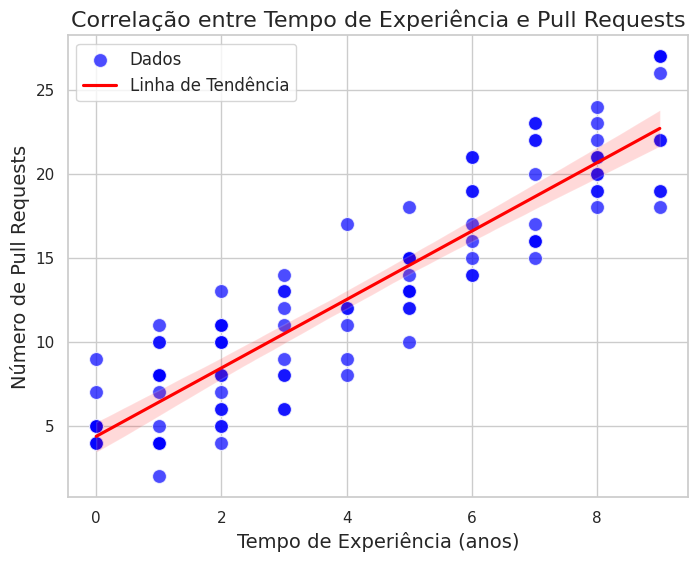

In [ ]:
# Este plot já usa a regressão linear para desenhar a linha de tendencia
# Ver mais em: https://seaborn.pydata.org/generated/seaborn.regplot.html
# Configuração do estilo
sns.set(style="whitegrid")

# Criando um gráfico de dispersão
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pontos, x="tempo_experiencia", y="pull_requests", color="blue", s=100, alpha=0.7, label="Dados")

# Desenhand uma linha de tendência
sns.regplot(data=pontos, x="tempo_experiencia", y="pull_requests", scatter=False, color="red", label="Linha de Tendência")

# Personalizar o gráfico
plt.title("Correlação entre Tempo de Experiência e Pull Requests", fontsize=16)
plt.xlabel("Tempo de Experiência (anos)", fontsize=14)
plt.ylabel("Número de Pull Requests", fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 'Handmade' KNN - Meu primeiro classificador

## Definindo métodos para o KNN

**Distância Euclideana =**
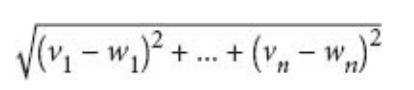

In [ ]:
def vector_subtract(v, w):
  """subtrai elementos correspondentes"""
  return [v_i - w_i for v_i, w_i in zip(v, w)]

def sum_of_squares(v):
  """v_1 * v_1 + ... + v_n * v_n"""
  return dot(v, v)

def squared_distance(v, w):
  """(v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
  return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
  return math.sqrt(squared_distance(v, w[0]))

In [ ]:
def majority_vote(rotulos):
  """presume que as etiquetas são ordenadas do mais próximo para o mais distante"""
  vote_counts = Counter(rotulos)
  winner, winner_count = vote_counts.most_common(1)[0]
  num_winners = len([count for count in vote_counts.values() if count == winner_count])
  if num_winners == 1:
    return winner
    # vencedor único, então o devolve
  else:
    return majority_vote(rotulos[:-1]) # tenta novamente sem o mais distante

In [ ]:
def clasificador_knn(k, pontos_rotulados, novo_ponto):
  """cada ponto rotulado deveria ser um par (point, label)"""
  # organiza os pontos rotulados do mais próximo para o mais distante
  by_distance = sorted(pontos_rotulados, key=lambda point_and_label: distance(point_and_label[0], novo_ponto))
  # encontra os rótulos para os k mais próximos
  k_nearest_labels = [label for _, label in by_distance[:k]]
  # e os deixa votar
  return majority_vote(k_nearest_labels)

## Treino e teste (80/20)

In [ ]:
n_treino = int(0.8 * len(pontos))  # 80% para treinob

In [ ]:
treino = pontos[:n_treino]
teste = pontos[n_treino:]
print("Tamanhos de treino e teste são {} e {}, respectivamente".format(len(treino), len(teste)))

Tamanhos de treino e teste são 83 e 21, respectivamente


## Estrutura de dados para o modelo

In [ ]:
# Criando uma estrutura seguindo a lógica: [([long1, lat1], "Python"), ([long2, lat2], "R"), ...]
estrutura_treino = [([p.x, p.y], lang) for p, lang in zip(treino["geometry"], treino["linguagem"])]
# imprimindo cabeçalho com 3 primeiras linhas
estrutura_treino[:3]

[([-55.16490483419034, 0.5890120225781743], 'Python'),
 ([-58.39086772107771, -2.4484306976118013], 'R'),
 ([-56.07925125694817, -11.410947659101218], 'Python')]

In [ ]:
# Criando uma estrutura seguindo a lógica: [([long1, lat1], "Python"), ([long2, lat2], "R"), ...]
estrutura_teste = [([p.x, p.y], lang) for p, lang in zip(teste["geometry"], teste["linguagem"])]
# imprimindo cabeçalho com 3 primeiras linhas
estrutura_teste[:3]

[([-59.75941371885364, -1.8758059480738964], 'Python'),
 ([-38.421110225176704, -10.508758230912381], 'R'),
 ([-55.02172649848866, -31.20017631530742], 'Python')]

In [ ]:
# Dividindo a estrutura em treino e teste
treino = dados[:n_treino]
teste = dados[n_treino:]
print("Tamanhos de treino e teste são {} e {}, respectivamente".format(len(treino), len(teste)))

Tamanhos de treino e teste são 83 e 21, respectivamente


## Plotando os pontos (treino e teste) no mapa

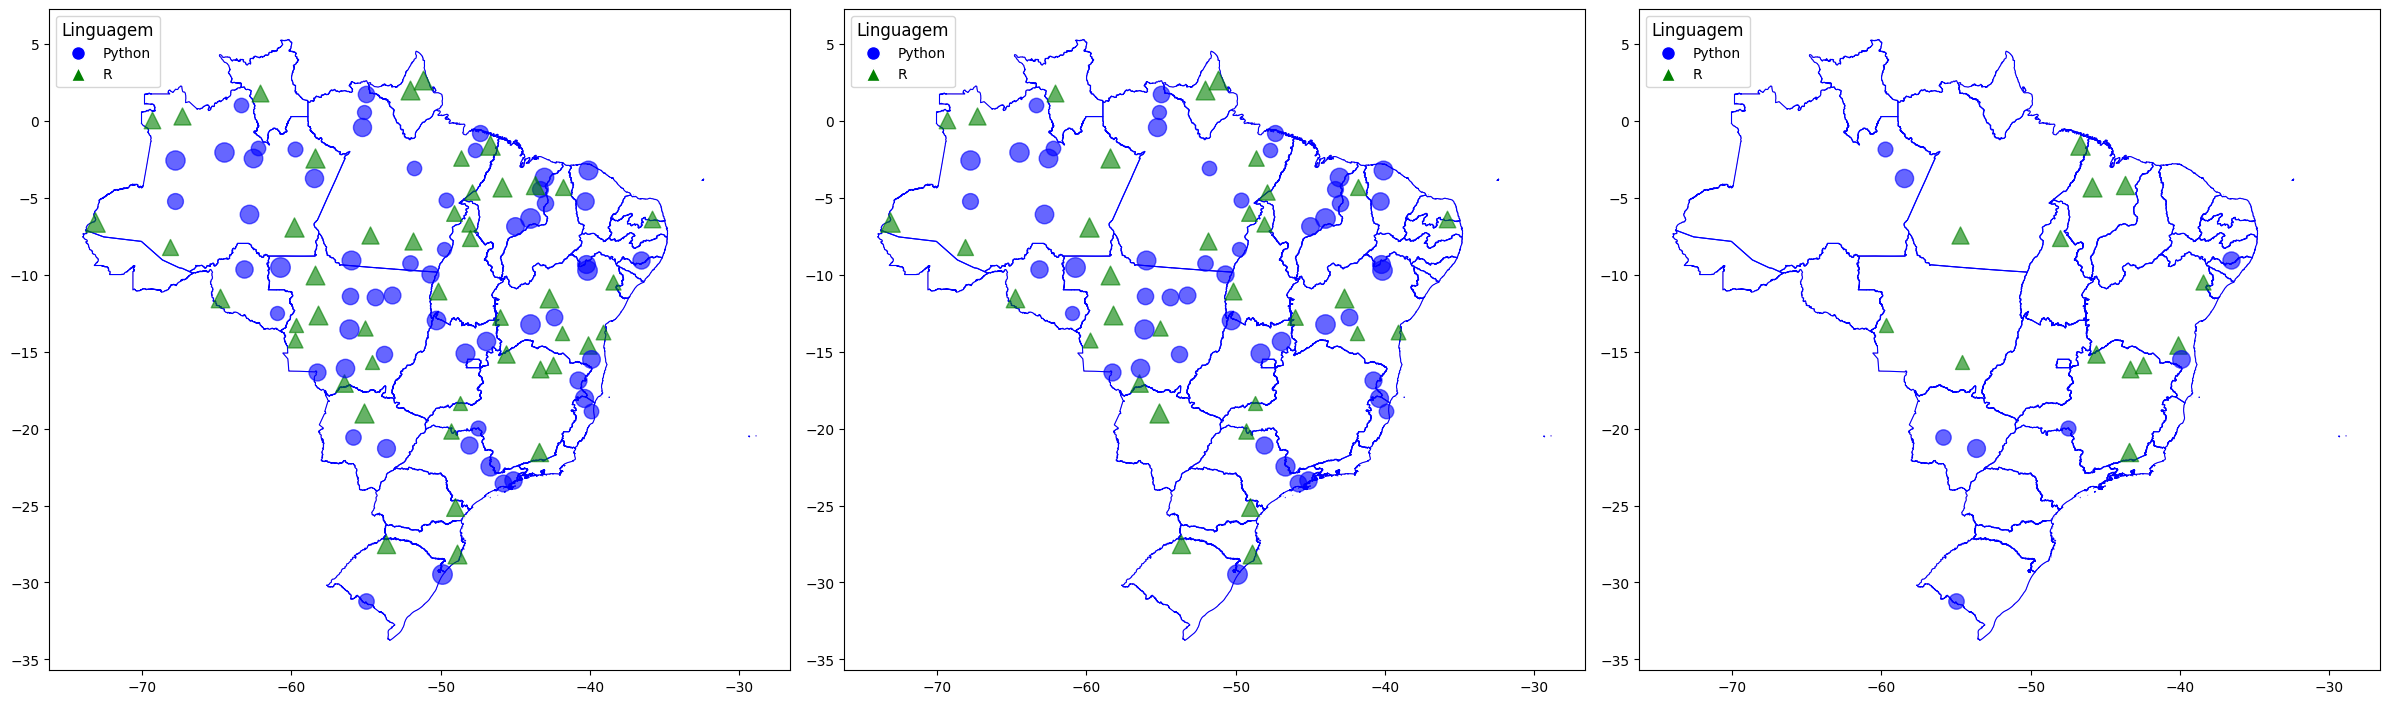

In [ ]:
# Função auxiliar para plotar pontos no mapa
def plot_points_on_map(ax, data, title):
  # Adicionar cada camada
  brasil.plot(ax=ax, color='white', linewidth=0.2, edgecolor='red', label='Brasil')
  estados.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.8, label='Estados')

  # Caso se deseje plotar os pontos sem discriminação de linguagem
  # pontos.plot(ax=ax, color='green', markersize=100, label='Cidades')  # Adicionar pontos

  # Pontos com marcadores diferentes para Python e R
  for _, row in data.iterrows():
      if row.geometry:  # Só certificando que a geometria não é None
          if row['linguagem'] == 'Python':
              ax.scatter(row.geometry.x, row.geometry.y, color='blue', marker='o',
                        s=row['pull_requests'] + 100, alpha=0.6)
          elif row['linguagem'] == 'R':
              ax.scatter(row.geometry.x, row.geometry.y, color='green', marker='^',
                        s=row['pull_requests'] + 100, alpha=0.6)

  # Criar handles para legenda personalizada
  handles = [
      Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Python'),
      Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='R')
  ]

  # pontos.plot(ax=ax, color=pontos['linguagem'].map({'Python': 'blue', 'R': 'green'}),
  #             markersize=100, alpha=0.6, label='Desenvolvedores')

  # Personalização
  ax.legend(handles=handles, title="Linguagem", loc="upper left", fontsize=10, title_fontsize=12)

# Criar os gráficos
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=False, sharey=False)

# Gráfico 1: Pontos no treino e teste
plot_points_on_map(axes[0], pontos, "Pontos no Treino e Teste")

# Gráfico 2: Pontos no treino
plot_points_on_map(axes[1], treino, "Pontos no Treino")

# Gráfico 3: Pontos no teste
plot_points_on_map(axes[2], teste, "Pontos no Teste")

# Ajustar layout
plt.tight_layout()
plt.show()

## Minhas primeiras predições

In [ ]:
print("""
Pelos dados em 'estrutura_teste[0]',
caso as coordenadadas '{}' sejam providas,
o valor predito deveria ser '{}'.
Lembre que este dado não está no treinamento.
""".format(estrutura_teste[0][0], estrutura_teste[0][1]))


Pelos dados em 'estrutura_teste[0]', 
caso as coordenadadas '[-59.75941371885364, -1.8758059480738964]' sejam providas, 
o valor predito deveria ser 'Python'.
Lembre que este dado não está no treinamento. 



In [ ]:
# Primeira tentativa cm K igual a 5
k = 5
pontos_rotulados = estrutura_treino
novo_ponto = estrutura_teste[0]
clasificador_knn(k, pontos_rotulados, novo_ponto)

'Python'

In [ ]:
# E se diminuirmos o número de vizinhos?
k = 1
pontos_rotulados = estrutura_treino
novo_ponto = estrutura_teste[0]
clasificador_knn(k, pontos_rotulados, novo_ponto)

'R'

## O quanto acertamos?

In [ ]:
# tenta vários valores diferentes para k
for k in [1, 3, 5, 7]:
  acertos = 0
  erros = 0
  for novo_ponto in estrutura_teste:
    coordenadas, linguagem_correta = novo_ponto
    outros_pontos = [outro_ponto for outro_ponto in estrutura_teste if outro_ponto != novo_ponto]
    linguagem_predita = clasificador_knn(k, pontos_rotulados, novo_ponto)
    if linguagem_correta == linguagem_predita:
      acertos += 1
    else:
      erros += 1
  print("{} vizinho[s]: {} de {}. O modelo errou {} vezes".format(k, acertos, len(estrutura_teste), erros))

1 vizinho[s]: 6 de 21. O modelo errou 15 vezes
3 vizinho[s]: 5 de 21. O modelo errou 16 vezes
5 vizinho[s]: 8 de 21. O modelo errou 13 vezes
7 vizinho[s]: 7 de 21. O modelo errou 14 vezes


## Apresentando algumas métricas

# Qualificando as predições
Considerando uma predição binárias (com dois rótulos), suponha que o rótulo positivo seja o 'Python' e o negativo o 'R'. Podemos então definir as seguintes
*   **Verdadeiro positivo (VP)**: Saída correta pelo modelo na predição de um rótulo positivo 'Python'.  
*   **Verdadeiro negativo (VN)**: Saída correta pelo modelo na predição de um rótulo negativo 'R'.
*   **Falso positivo (FP)**: Saída incorreta pelo modelo na predição de um rótulo negativo 'R'.
*   **Falso Negativo (FN)**: Saída incorreta pelo modelo na predição de um rótulo positivo 'Python'.


---

# Matrix de confusão

|                        |        | **rótulo  positivo** | **rótulo  negativo** |   |
|:----------------------:|:------:|:--------------------:|:--------------------:|:-:|
|                        |        |        Python        |           R          |   |
| **predição  positiva** | Python |          VP          |          FP          |   |
| **predição  negativa** |    R   |          FN          |          VN          |   |


---

# Tabela de Métricas

| **Métrica**        | **Equação**                                                                                          | **Definição**                                                                                                                                          | **Foco**                                     | **Quando usar?**            |
|--------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------|-----------------------------|
|    **Acurácia**    | $$ \text{Acurácia} = \frac{VP + VN}{VP + VN + FP + FN} $$                                            | Proporção de predições corretas em relação <br> ao total de casos avaliados.                                                                           | Predições <br> corretas                      | Classes balanceadas.        |
|    **Precisão**    | $$ \text{Precisão} = \frac{VP}{VP + FP} $$                                                           | Proporção de predições positivas corretas em <br> relação ao total de predições positivas feitas pelo modelo.                                          | Previsões positivas <br>  corretas           | Minimizar falsos positivos. |
|    **Revocação**   | $$ \text{Revocação} = \frac{VP}{VP + FN} $$                                                          | Proporção de casos positivos corretamente <br> identificados pelo modelo em relação ao total de <br>  casos positivos reais                            | Casos positivos <br>  corretamente previstos | Minimizar falsos negativos. |
|       **F1**       | $$ F1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}} $$ | Média harmônica entre precisão e revocação. <br>  Equilibra a importância de ambas as métricas, <br> sendo útil em cenários de classes desbalanceadas. | Equilíbrio entre <br>  precisão e revocação  | Dados desbalanceados.       |
| **Especificidade** | $$ \text{Especificidade} = \frac{VN}{VN + FP} $$                                                     | Proporção de casos negativos corretamente <br> identificados pelo modelo em relação ao total <br> de casos negativos reais.                            | Casos negativos <br>  corretamente previstos | Reduzir falsos positivos.   |


